In [12]:
from loadData import *
from models import Model
from helper import *
import pathlib
import os
import cc3d
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    NormalizeIntensityd,
    Orientationd,
)
import numpy as np
import torch
from monai.data import CacheDataset
import pandas as pd
from generate_confusion_matrix import score

# current_dir = pathlib.Path(os.getcwd())

checkpoint_path = pathlib.Path( "checkpoints/best_model-v14.ckpt")
assert os.path.exists(checkpoint_path)

model = Model.load_from_checkpoint(checkpoint_path=checkpoint_path)
model.eval()

root = load_data(train=False)

copick_user_name = "copickUtils"
copick_segmentation = "paintedPicks"
voxel_size = 10
tomo_type = "denoised"

inference_transforms = Compose(
    [
        EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        NormalizeIntensityd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
    ]
)


classes = [1, 2, 3, 4, 5, 6]
id_to_name = {
    1: "apo-ferritin",
    2: "beta-amylase",
    3: "beta-galactosidase",
    4: "ribosome",
    5: "thyroglobulin",
    6: "virus-like-particle",
}

thresholds = {
    "apo-ferritin" : 60,
    "beta-amylase" : 65,
    "beta-galactosidase": 90,
    "ribosome" : 150,
    "thyroglobulin" : 130,
    "virus-like-particle" : 135,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
debug=False
probability_list = []
with torch.no_grad():
    location_df=[]
    for run in root.runs:
        
        print(f"Processing run {run.name}")
        tomo = run.get_voxel_spacing(voxel_size)
        if not tomo:
            break
        tomo = tomo.get_tomogram(tomo_type).numpy()
        # print(type(tomo))
        D, H, W = tomo.shape
        probability = np.zeros((7, D, H, W), dtype=np.float32)
        count = np.zeros((7, D, H, W), dtype=np.float32)
        # pad_volume = np.pad(tomo, [[0, 0], [0, 640 - H], [0, 640 - W]], mode='constant', constant_values=0)

        tomo_patches, coordinates = extract_3d_patch([tomo], 96)

        tomo_patched_data = [{"image": img} for img in tomo_patches]
        tomo_ds = CacheDataset(
            data=tomo_patched_data, transform=inference_transforms, cache_rate=1.0
        )
        for i in range(len(tomo_ds)):
            input_tensor = tomo_ds[i]["image"].unsqueeze(0).to(device)
            model_output = model(input_tensor)
            probs = torch.softmax(model_output[0],dim=0).cpu().numpy()
            x,y,z = coordinates[i]
            probability[:, x:x+96, y:y+96, z:z+96] += probs[:,:,:,:]
            count[:, x:x+96, y:y+96, z:z+96]  += 1
            if debug:
                print("probs: ", probs)
                print("probability: ", probability)
                print("count: ", count)
                debug = False

        probability = probability / (count + 0.0001)
        probability_list.append((run.name, probability))
        location = {}
        for c in classes:
            cc = cc3d.connected_components(probability[c] > 0.5)
            stats = cc3d.statistics(cc)
            zyx = stats["centroids"][1:] * 10.012444
            # volume_threshold = 4*np.pow(thresholds[id_to_name[c]], 3)
            # zyx_large = zyx[stats["voxel_counts"][1:] > volume_threshold]
            xyz = np.ascontiguousarray(zyx[:, ::-1])
            location[id_to_name[c]] = xyz

        df = dict_to_df(location, run.name)
        location_df.append(df)
    location_df = pd.concat(location_df)
    location_df.insert(0,"id", range(len(location_df)))
    location_df.rename(columns=({location_df.columns[0]:'id'}),inplace=True)
solution = pd.read_csv("outputs/solution.csv")
df = score(solution, location_df)

Writing configs to /home/xie.chang/cryoET-kaggle-2024/kaggle/working/copick_test.configs
Processing run TS_5_4


Loading dataset: 100%|██████████| 98/98 [00:00<00:00, 270.84it/s]


Processing run TS_69_2


Loading dataset: 100%|██████████| 98/98 [00:00<00:00, 242.54it/s]


Processing run TS_6_4


Loading dataset: 100%|██████████| 98/98 [00:00<00:00, 293.11it/s]


0.5987491719222532


In [16]:

thresholds_list = [0.1*x for x in range(1,11)]
solution = pd.read_csv("outputs/solution.csv")

for threshold in thresholds_list:
    location_df = []
    for name, probability in probability_list:       
        location = {}
        for c in classes:
            cc = cc3d.connected_components(probability[c] > threshold)
            stats = cc3d.statistics(cc)
            zyx = stats["centroids"][1:] * 10.012444
            volume_threshold = 4*np.pow(thresholds[id_to_name[c]], 3)
            zyx_large = zyx[stats["voxel_counts"][1:] > volume_threshold]
            xyz = np.ascontiguousarray(zyx[:, ::-1])
            location[id_to_name[c]] = xyz
        df = dict_to_df(location, name)
        location_df.append(df)

    location_df = pd.concat(location_df)
    location_df.insert(0,"id", range(len(location_df)))
    location_df.rename(columns=({location_df.columns[0]:'id'}),inplace=True)
    # location_df.to_csv("outputs/submission.csv", index=False)
    
    print(f'Threshold: {threshold}, fbeta: ', end="")
    df = score(solution, location_df)
    print(df)

Threshold: 0.1, fbeta: 0.4129217413381719
                     total_tp  total_fp  total_fn  precision    recall  \
apo-ferritin            139.0     654.0       0.0   0.175284  1.000000   
beta-amylase             28.0     413.0       3.0   0.063492  0.903226   
beta-galactosidase       40.0    1557.0       0.0   0.025047  1.000000   
ribosome                142.0    1770.0       0.0   0.074268  1.000000   
thyroglobulin            94.0    2691.0       0.0   0.033752  1.000000   
virus-like-particle      30.0    2369.0       0.0   0.012505  1.000000   

                        fbeta  
apo-ferritin         0.783228  
beta-amylase         0.508004  
beta-galactosidase   0.303979  
ribosome             0.576960  
thyroglobulin        0.372581  
virus-like-particle  0.177145  
Threshold: 0.2, fbeta: 0.4569676498844613
                     total_tp  total_fp  total_fn  precision    recall  \
apo-ferritin            139.0     527.0       0.0   0.208709  1.000000   
beta-amylase             

In [17]:
thresholds_list = [0.9+0.01*x for x in range(1,10)]
solution = pd.read_csv("outputs/solution.csv")

for threshold in thresholds_list:
    location_df = []
    for name, probability in probability_list:       
        location = {}
        for c in classes:
            cc = cc3d.connected_components(probability[c] > threshold)
            stats = cc3d.statistics(cc)
            zyx = stats["centroids"][1:] * 10.012444
            volume_threshold = 4*np.pow(thresholds[id_to_name[c]], 3)
            zyx_large = zyx[stats["voxel_counts"][1:] > volume_threshold]
            xyz = np.ascontiguousarray(zyx[:, ::-1])
            location[id_to_name[c]] = xyz
        df = dict_to_df(location, name)
        location_df.append(df)

    location_df = pd.concat(location_df)
    location_df.insert(0,"id", range(len(location_df)))
    location_df.rename(columns=({location_df.columns[0]:'id'}),inplace=True)
    # location_df.to_csv("outputs/submission.csv", index=False)
    
    print(f'Threshold: {threshold}, fbeta: ', end="")
    df = score(solution, location_df)
    print(df)
# Threshold: 0.9, fbeta: 0.6729074449493714

Threshold: 0.91, fbeta: 0.6733479420139249
                     total_tp  total_fp  total_fn  precision    recall  \
apo-ferritin            139.0     161.0       0.0   0.463333  1.000000   
beta-amylase             20.0     115.0      11.0   0.148148  0.645161   
beta-galactosidase       40.0     381.0       0.0   0.095012  1.000000   
ribosome                142.0     888.0       0.0   0.137864  1.000000   
thyroglobulin            94.0     735.0       0.0   0.113390  1.000000   
virus-like-particle      30.0     783.0       0.0   0.036900  1.000000   

                        fbeta  
apo-ferritin         0.936212  
beta-amylase         0.538827  
beta-galactosidase   0.640905  
ribosome             0.731072  
thyroglobulin        0.684955  
virus-like-particle  0.394432  
Threshold: 0.92, fbeta: 0.6753635859915535
                     total_tp  total_fp  total_fn  precision    recall  \
apo-ferritin            139.0     154.0       0.0   0.474403  1.000000   
beta-amylase           

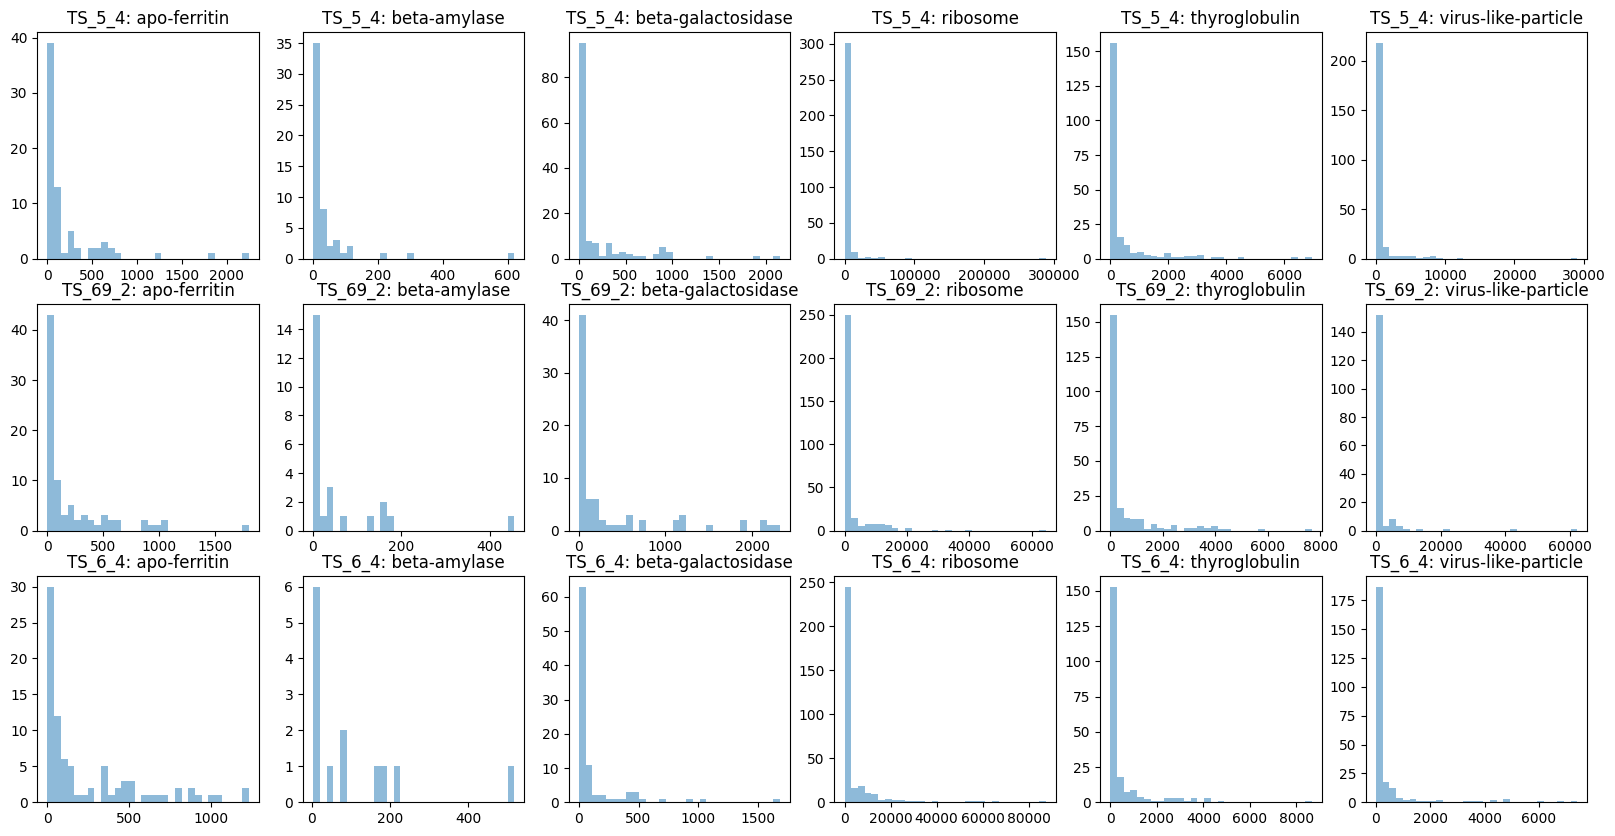

Threshold: 0.99, fbeta: 0.7217580026018284
                     total_tp  total_fp  total_fn  precision    recall  \
apo-ferritin            136.0     104.0       3.0   0.566667  0.978417   
beta-amylase             17.0      75.0      14.0   0.184783  0.548387   
beta-galactosidase       40.0     267.0       0.0   0.130293  1.000000   
ribosome                142.0     803.0       0.0   0.150265  1.000000   
thyroglobulin            94.0     559.0       0.0   0.143951  1.000000   
virus-like-particle      30.0     634.0       0.0   0.045181  1.000000   

                        fbeta  
apo-ferritin         0.938312  
beta-amylase         0.491497  
beta-galactosidase   0.718057  
ribosome             0.750389  
thyroglobulin        0.740844  
virus-like-particle  0.445804  


In [22]:
import matplotlib.pyplot as plt
volume_threshold_list = [0.1, 1, 1.5, 2, 5]
threshold = 0.99
location_df = []
# fig, axes = plt.subplot(3, 6, figsize=(10,5))
fig = plt.figure(figsize=(20,10))
i = 0


for name, probability in probability_list:       
    location = {}
    for c in classes:
        cc = cc3d.connected_components(probability[c] > threshold)
        stats = cc3d.statistics(cc)
        zyx = stats["centroids"][1:] * 10.012444
        volume_threshold = 4*np.pow(thresholds[id_to_name[c]], 3)
        # voxel_counts = stats["voxel_counts"][1:]  # 忽略背景
        # print("current run name", name)
        # print("Minimum:", np.min(voxel_counts))
        # print("Maximum:", np.max(voxel_counts))
        # print("Mean:", np.mean(voxel_counts))
        # print("Median:", np.median(voxel_counts))
        # print("Standard Deviation:", np.std(voxel_counts))
        voxel_counts = stats["voxel_counts"][1:]  # 忽略背景
        plt.subplot(3,6,6*i+c)
        
        plt.hist(voxel_counts, bins=30, alpha=0.5)
        plt.title(f"{name}: {id_to_name[c]}")
        # print()
        zyx_large = zyx[stats["voxel_counts"][1:] > volume_threshold]
        xyz = np.ascontiguousarray(zyx[:, ::-1])
        location[id_to_name[c]] = xyz
    df = dict_to_df(location, name)
    location_df.append(df)
    i+=1
plt.show()
location_df = pd.concat(location_df)
location_df.insert(0,"id", range(len(location_df)))
location_df.rename(columns=({location_df.columns[0]:'id'}),inplace=True)

print(f'Threshold: {threshold}, fbeta: ', end="")
df = score(solution, location_df)
print(df)

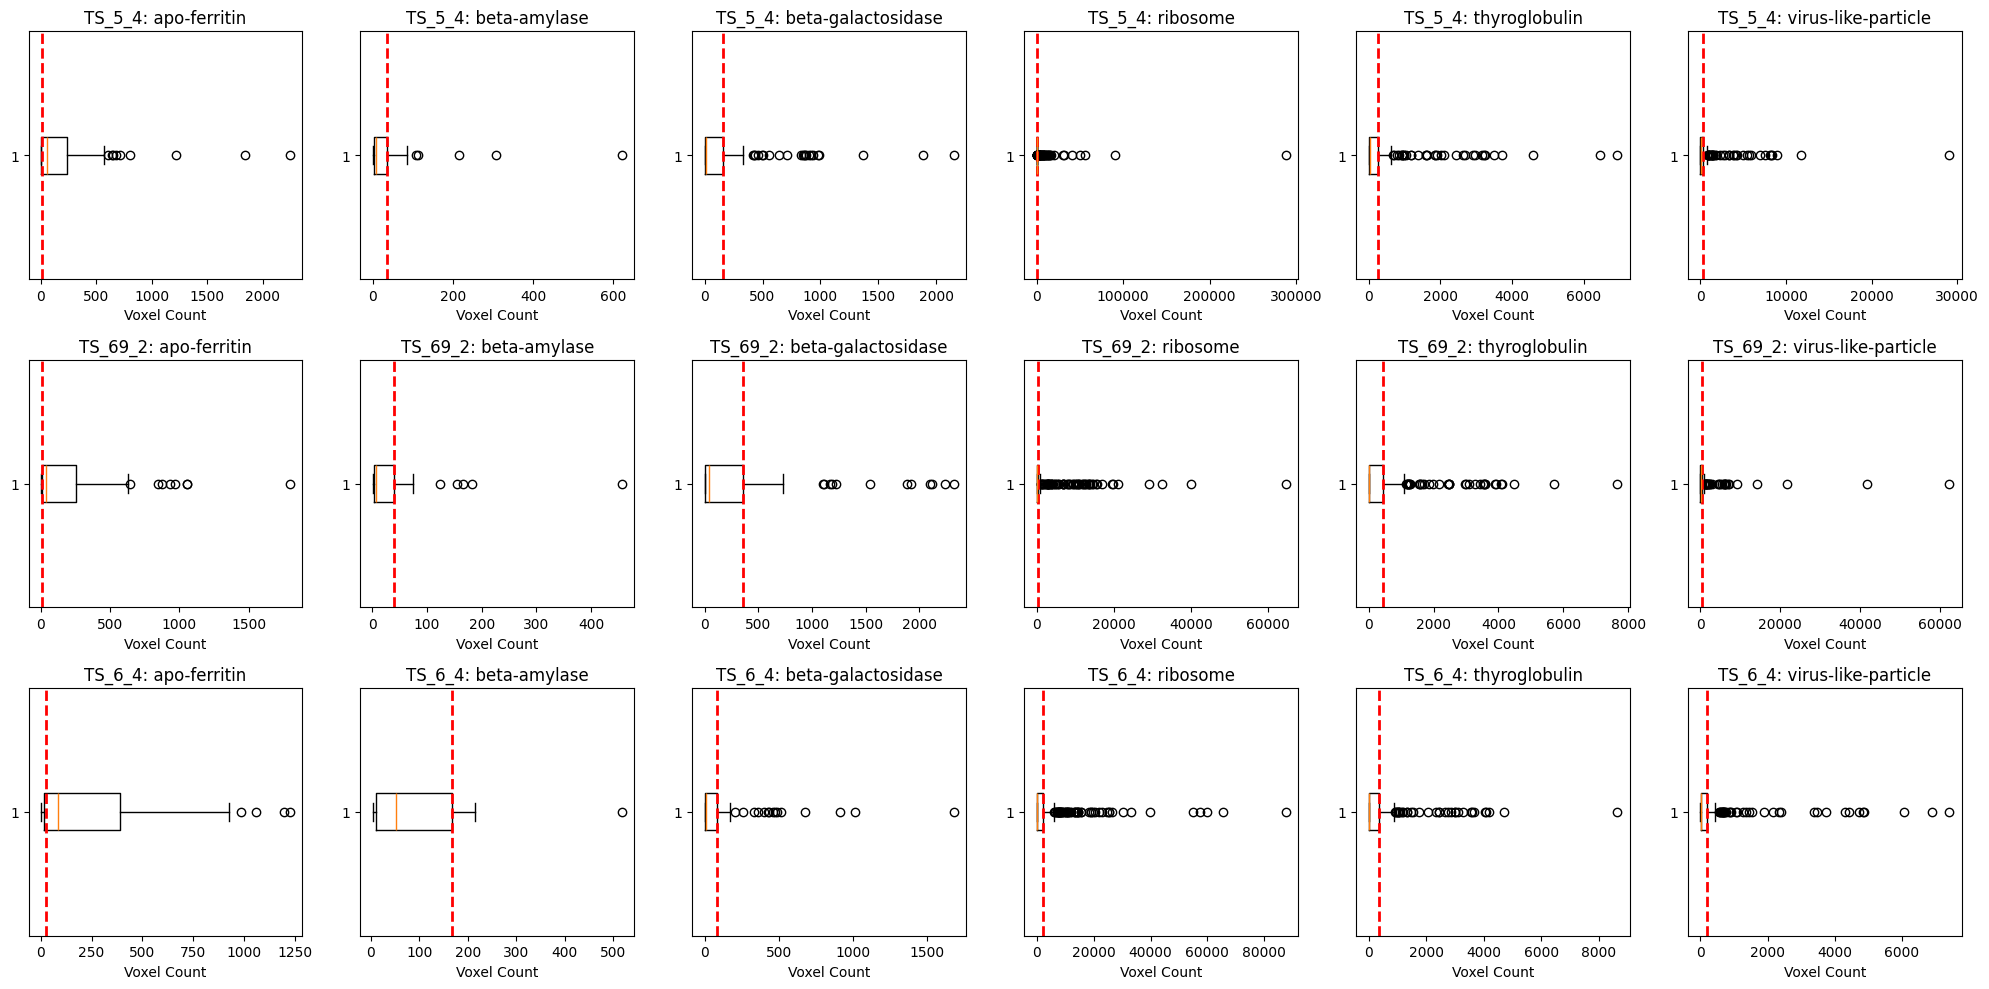

Threshold: 0.99, fbeta: 0.8749727403415088
                     total_tp  total_fp  total_fn  precision    recall  \
apo-ferritin            134.0      31.0       5.0   0.812121  0.964029   
beta-amylase              8.0      15.0      23.0   0.347826  0.258065   
beta-galactosidase       33.0      44.0       7.0   0.428571  0.825000   
ribosome                142.0      95.0       0.0   0.599156  1.000000   
thyroglobulin            91.0      72.0       3.0   0.558282  0.968085   
virus-like-particle      30.0     137.0       0.0   0.179641  1.000000   

                        fbeta  
apo-ferritin         0.953537  
beta-amylase         0.262042  
beta-galactosidase   0.782427  
ribosome             0.962136  
thyroglobulin        0.928014  
virus-like-particle  0.788253  


In [32]:
import matplotlib.pyplot as plt
volume_threshold_list = [0.1, 1, 1.5, 2, 5]
threshold = 0.99
location_df = []
# fig, axes = plt.subplot(3, 6, figsize=(10,5))
fig = plt.figure(figsize=(20,10))
i = 0

# total_counts
for name, probability in probability_list:       
    location = {}
    for c in classes:
        cc = cc3d.connected_components(probability[c] > threshold)
        stats = cc3d.statistics(cc)
        zyx = stats["centroids"][1:] * 10.012444
        voxel_counts = stats["voxel_counts"][1:]
        # volume_threshold = 4*np.pow(thresholds[id_to_name[c]]*0.8/10, 3)
        # volume_threshold = np.median(voxel_counts)
        if c == 1:
            volume_threshold = np.percentile((voxel_counts), 30)
        else:
            volume_threshold = np.percentile((voxel_counts), 75)

        # voxel_counts = stats["voxel_counts"][1:]  # 忽略背景
        # print("current run name", name)
        # print("Minimum:", np.min(voxel_counts))
        # print("Maximum:", np.max(voxel_counts))
        # print("Mean:", np.mean(voxel_counts))
        # print("Median:", np.median(voxel_counts))
        # print("Standard Deviation:", np.std(voxel_counts))
        # voxel_counts = stats["voxel_counts"][1:]  # 忽略背景

        plt.subplot(3,6,6*i+c)
        plt.boxplot(voxel_counts, vert=False)
        plt.axvline(x=volume_threshold, color='red', linestyle='--', linewidth=2, label=f"Value = {volume_threshold}")
        plt.xlabel("Voxel Count")
        # plt.hist(voxel_counts, bins=30, alpha=0.5)
        plt.title(f"{name}: {id_to_name[c]}")
        # print()
        zyx_large = zyx[stats["voxel_counts"][1:] > volume_threshold]
        xyz = np.ascontiguousarray(zyx_large[:, ::-1])
        location[id_to_name[c]] = xyz
    df = dict_to_df(location, name)
    location_df.append(df)
    i+=1
plt.tight_layout()
plt.show()
location_df = pd.concat(location_df)
location_df.insert(0,"id", range(len(location_df)))
location_df.rename(columns=({location_df.columns[0]:'id'}),inplace=True)

print(f'Threshold: {threshold}, fbeta: ', end="")
df = score(solution, location_df)
print(df)